# Analysis and Visualization of Complex Agro-Environmental Data
---
### Exercise #5 - correction

In [1]:
import pandas as pd
import numpy as np
import zipfile
import seaborn as sns # For plotting
import matplotlib.pyplot as plt # For showing plots
import scipy.stats as sts
import scikit_posthocs as sp
import statsmodels.stats as stm
from statsmodels.graphics.gofplots import qqplot
import math

In [2]:
df = pd.read_csv('../exemplos/EFIplus_medit.zip',compression='zip', sep=";")

In [3]:
# clean up the dataset to remove unnecessary columns (eg. REG) 
df.drop(df.iloc[:,5:15], axis=1, inplace=True)

# let's rename some columns so that they make sense
df.rename(columns={'Sum of Run1_number_all':'Total_fish_individuals'}, inplace=True) # inplace="True" means that df will be updated

# for sake of consistency, let's also make all column labels of type string
df.columns = list(map(str, df.columns))

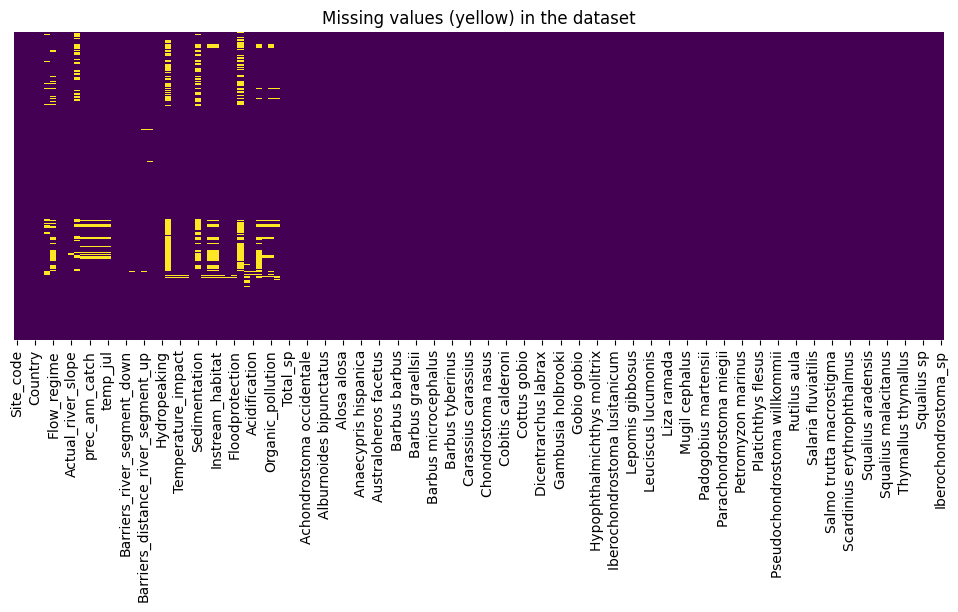

In [4]:
# a good way of detecting missing values in the dataset
plt.figure(figsize=(12,4))
sns.heatmap(df.isnull(),cbar=False,cmap='viridis',yticklabels=False)
plt.title('Missing values (yellow) in the dataset');

In [5]:
df = df.dropna() # drops rows when at least one element is a missing value

##### Exercise 5.1

In [6]:
# standardize the Mean Annual Temperature
df['temp_ann_st'] = (df['temp_ann'] - df['temp_ann'].mean()) / df['temp_ann'].std()
df['temp_ann_st']

18     -2.164499
19     -1.588213
28     -0.435640
32     -1.169095
43     -1.221485
          ...   
5006    0.769322
5007    0.821712
5008    0.821712
5009   -0.278471
5010    0.716933
Name: temp_ann_st, Length: 2822, dtype: float64

In [7]:
# simpler alternative
sts.zscore(df['temp_ann'])

18     -2.164883
19     -1.588494
28     -0.435717
32     -1.169303
43     -1.221702
          ...   
5006    0.769459
5007    0.821858
5008    0.821858
5009   -0.278520
5010    0.717060
Name: temp_ann, Length: 2822, dtype: float64

In [8]:
Tst_mean = round(df['temp_ann_st'].mean())
Tst_SD = df['temp_ann_st'].std()

# standard error
SE = Tst_SD/math.sqrt(len(df))

# Compute the 95% CI manually 
lower = Tst_mean-1.96*SE
upper = Tst_mean+1.96*SE
print('95% CI:', (lower, upper))

# Alternative using the scipy function norm.interval
CI = sts.norm.interval(0.95, Tst_mean, scale=SE)
print('95% CI:', CI)

# Assuming a t-distribution instead
CI_t = sts.t.interval(confidence=0.95, df=len(df)-1, loc=Tst_mean, scale=SE)
print('95% CI t distribution:', CI_t)

print(Tst_mean)
print(Tst_SD)

95% CI: (-0.03689585396339492, 0.03689585396339492)
95% CI: (-0.036895175993420126, 0.036895175993420126)
95% CI t distribution: (-0.03691101273899835, 0.03691101273899835)
0
1.0


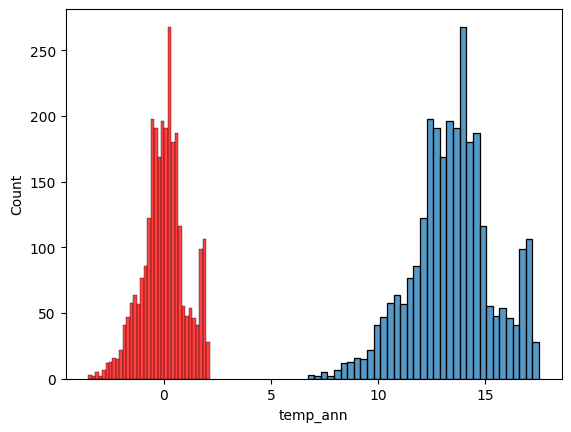

In [9]:
sns.histplot(df['temp_ann'])
sns.histplot(df['temp_ann_st'], color='red')
plt.show()

##### Exercise 5.2

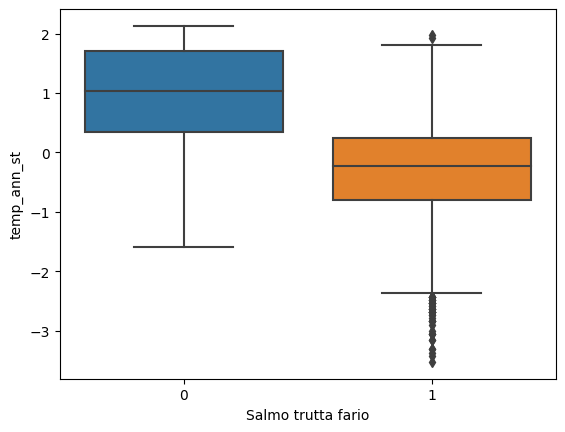

In [10]:
sns.boxplot(data=df,x='Salmo trutta fario',y='temp_ann_st')
plt.show()

In [11]:
# Run t test
# H0 : The samples are drawn from populations with equal means

sample1 = df[df['Salmo trutta fario']==0]['temp_ann']
sample2 = df[df['Salmo trutta fario']==1]['temp_ann']

print('Mean of sample 1 = ', sample1.mean())
print('Mean of sample 2 = ', sample2.mean())

# t-test - tests the null hypothesis that sample 1 and 2 are derived from populations with the same mean
stat, p = sts.ttest_ind(sample1, sample2)
print('Statistics=%.3f, p=%.3f' % (stat, p)) # print outputs
alpha=0.05
if p > alpha:
 print('fail to reject H0. Rejecting H0 has an error probability >0.05')
else:
 print('reject H0 with an error probability <0.05)')

Mean of sample 1 =  15.21128205128205
Mean of sample 2 =  12.751714005876591
Statistics=37.454, p=0.000
reject H0 with an error probability <0.05)


In [12]:
# Run t test on standardized variables
# H0 : The samples are drawn from populations with equal means

sample1 = df[df['Salmo trutta fario']==0]['temp_ann_st']
sample2 = df[df['Salmo trutta fario']==1]['temp_ann_st']

print('Mean of sample 1 = ', sample1.mean())
print('Mean of sample 2 = ', sample2.mean())

# t-test - tests the null hypothesis that sample 1 and 2 are derived from populations with the same mean
stat, p = sts.ttest_ind(sample1, sample2)
print('Statistics=%.3f, p=%.3f' % (stat, p)) # print outputs
alpha=0.05
if p > alpha:
 print('fail to reject H0. Rejecting H0 has an error probability >0.05')
else:
 print('reject H0 with an error probability <0.05)')

Mean of sample 1 =  0.9324021405323514
Mean of sample 2 =  -0.3561575267459527
Statistics=37.454, p=0.000
reject H0 with an error probability <0.05)


##### Exercise 5.3

In [13]:
catchment_count = pd.crosstab(index = df['Catchment_name'], columns='count')
catchment_count.sort_values(by=['count'], ascending=False)

col_0,count
Catchment_name,
Galiza-Norte,702
Minho,699
Cantabrica,345
Douro,272
Tejo,235
Guadia,102
Galiza-Sul,95
Mondego,86
Ebro,61


In [14]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

dfsub = df[(df['Catchment_name']=='Galiza-Norte') | 
    (df['Catchment_name']=='Minho') |
    (df['Catchment_name']=='Cantabrica') |
    (df['Catchment_name']=='Douro') |
    (df['Catchment_name']=='Tejo') |
    (df['Catchment_name']=='Guadia') |
    (df['Catchment_name']=='Galiza-Sul') |
    (df['Catchment_name']=='Mondego')
    ]


<Axes: xlabel='Actual_river_slope', ylabel='Count'>

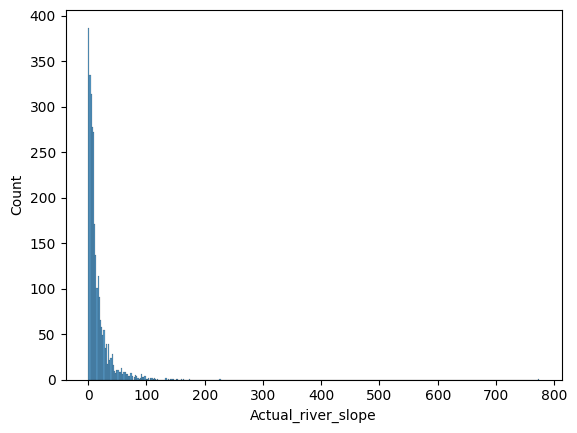

In [15]:
sns.histplot(df['Actual_river_slope'])

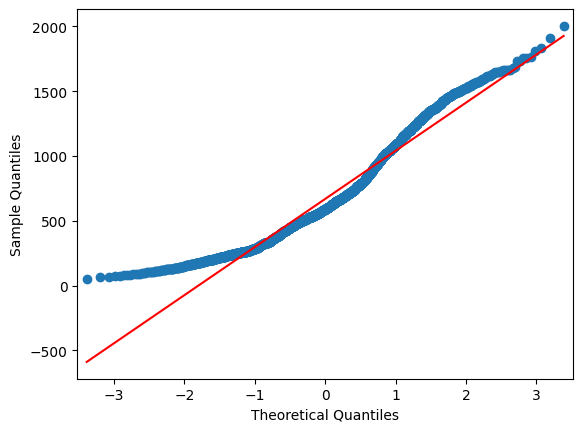

In [16]:
from statsmodels.graphics.gofplots import qqplot

qqplot(pd.Series(df['Elevation_mean_catch']), line='s')
plt.show()

In [17]:
# Although the distribution of the mean elevation is right skewed and seems to depart from normality we will nevertheless try to run ANOVA. 

mod = ols('Elevation_mean_catch ~ Catchment_name',
                data=dfsub).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2) # typ is the type of anova type to perform ('I','II' or 'III' = 1,2,3)
print(aov_table) # provides the usual ANOVA table

alpha=0.05
p=aov_table['PR(>F)'][0]

if p <= alpha:
 print('reject H0 that mean elevation values are equal among catchments')
else:
 print('fail to reject H0 that mean elevation values are equal among catchments')

# compute mean elevation for eacch catchment
dfsub[['Elevation_mean_catch','Catchment_name']].groupby('Catchment_name').mean()


                      sum_sq      df          F         PR(>F)
Catchment_name  1.044793e+08     7.0  157.17364  3.971010e-193
Residual        2.400654e+08  2528.0        NaN            NaN
reject H0 that mean elevation values are equal among catchments


,Elevation_mean_catch
Catchment_name,
Cantabrica,691.334815
Douro,804.740828
Galiza-Norte,472.279329
Galiza-Sul,724.237070
Guadia,360.718561
Minho,949.340015
Mondego,650.982885
Tejo,489.184222


In [18]:
# Multiple comparisons - perform Tukey's test 
tukey = stm.multicomp.pairwise_tukeyhsd(endog=dfsub['Elevation_mean_catch'],
                          groups=dfsub['Catchment_name'],
                          alpha=0.05)
#display results
print(tukey)

         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
   group1       group2     meandiff p-adj    lower     upper   reject
---------------------------------------------------------------------
  Cantabrica        Douro   113.406 0.0002   37.6078  189.2042   True
  Cantabrica Galiza-Norte -219.0555    0.0 -280.5173 -157.5936   True
  Cantabrica   Galiza-Sul   32.9023 0.9841   -75.407  141.2115  False
  Cantabrica       Guadia -330.6163    0.0 -435.9711 -225.2614   True
  Cantabrica        Minho  258.0052    0.0  196.4999  319.5105   True
  Cantabrica      Mondego  -40.3519 0.9597 -153.0173   72.3134  False
  Cantabrica         Tejo -202.1506    0.0  -281.215 -123.0862   True
       Douro Galiza-Norte -332.4615    0.0 -399.2247 -265.6983   True
       Douro   Galiza-Sul  -80.5038 0.3568 -191.9068   30.8993  False
       Douro       Guadia -444.0223    0.0 -552.5552 -335.4893   True
       Douro        Minho  144.5992    0.0    77.796  211.4023   True
       Douro      Mo

<Axes: xlabel='Catchment_name', ylabel='Actual_river_slope'>

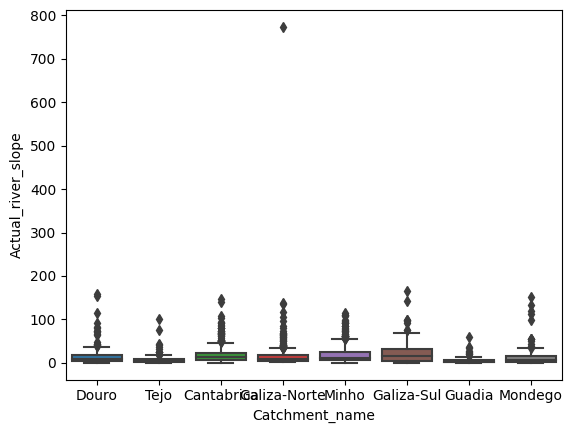

In [19]:
sns.boxplot(data=dfsub, x='Catchment_name', y='Actual_river_slope')

##### Exercise 5.4

Potential problems in the data used for hypothesis testing are: 
- Departure from the normal distribution
- Categories are highly unbalanced (very different number of samples for each category - see below). 
- Lack of independency among sampling sites. For example when we tested the effect of Actual_river_slope in the presence of Salmo trutta fario, we did not take into account that observations within each catchment might not be totally independent.



In [20]:
print(dfsub['Catchment_name'].value_counts())
print(df['Salmo trutta fario'].value_counts())

Galiza-Norte    702
Minho           699
Cantabrica      345
Douro           272
Tejo            235
Guadia          102
Galiza-Sul       95
Mondego          86
Name: Catchment_name, dtype: int64
1    2042
0     780
Name: Salmo trutta fario, dtype: int64
